In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato_dataset",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
)

Found 16013 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names

In [5]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 4 6 0 7 6 7 6 7 9 7 1 1 0 9 0 5 0 5 0 9 6 2 1 4 4 9 9 1 2 5]


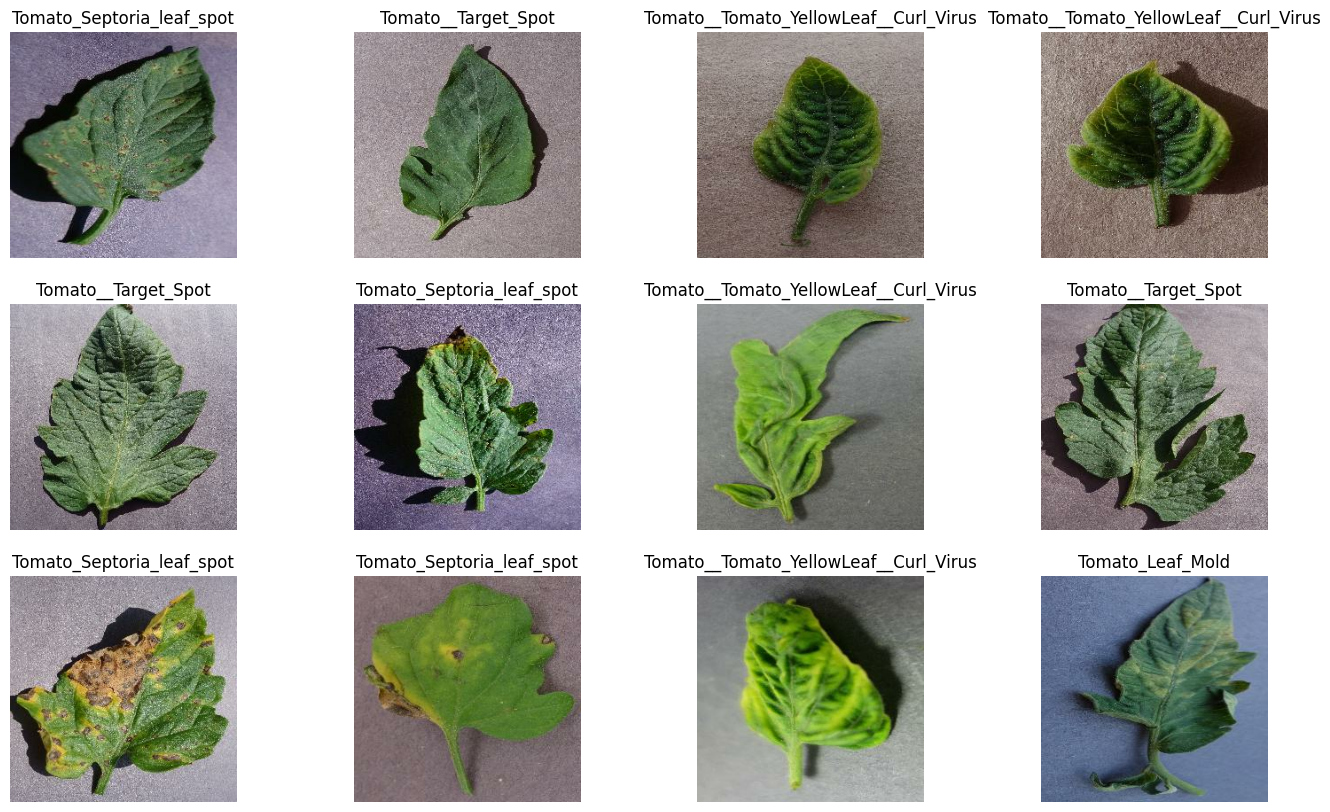

In [7]:
plt.figure(figsize=(17,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[labels_batch[i]])

In [8]:
len(dataset)

501

In [9]:
501*0.8

400.8

In [10]:
def split_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds,val_ds,test_ds = split_dataset(dataset)

In [12]:
len(train_ds)

400

In [13]:
len(val_ds)

50

In [14]:
len(test_ds)

51

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
from tensorflow.keras import layers, models
resize_and_rescale= tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 329s 821ms/step - accuracy: 0.4864 - loss: 1.4335 - val_accuracy: 0.5781 - val_loss: 1.4724
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 264s 659ms/step - accuracy: 0.6999 - loss: 0.8361 - val_accuracy: 0.4794 - val_loss: 1.7727
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 238s 595ms/step - accuracy: 0.7605 - loss: 0.7002 - val_accuracy: 0.7262 - val_loss: 0.8181
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 242s 605ms/step - accuracy: 0.8094 - loss: 0.5380 - val_accuracy: 0.6888 - val_loss: 1.0634
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 242s 603ms/step - accuracy: 0.8370 - loss: 0.4722 - val_accuracy: 0.7675 - val_loss: 0.7389
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 220s 548ms/step - accuracy: 0.8541 - loss: 0.4201 - val_accuracy: 0.7925 - val_loss: 0.6750
Epoch 7/50
260/400 ━━━━━━━━━━━━━━━━━━━━ 1:24 602ms/step - accuracy: 0.8730 - loss: 0.3724

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history['loss'][:5]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("saved") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../tomato.h5")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models2") + [0]])+1
model.save(f"../models2/{model_version}")